<a href="https://colab.research.google.com/github/VivekMuraleedharanGit/fastai_learning/blob/main/Pets_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pets Breed Image classification using the fastai and PyTorch

In this notebook I'm trying to create a dog vs cat classifier with the help of fastai and pytorch.This was covered as part of fastai coursehttps://docs.fast.ai/tutorial.vision.html


In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *


In [3]:
#dataset for the cat vs dogs

path = untar_data(URLs.PETS)


In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [5]:
files = get_image_files(path/'images')
len(files)

7390

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs

In [6]:
files[2],files[3]

(Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_199.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_50.jpg'))

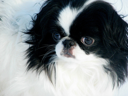

In [7]:
Image.open(files[2]).to_thumb(128,128)

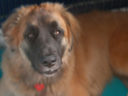

In [8]:
Image.open(files[3]).to_thumb(128,128)

In [9]:
#label fucntion 

def label_func(f):
  return "cat" if f[0].isupper() else "dog"


In [10]:

#creating a DataLoaders object
dls= ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(224))


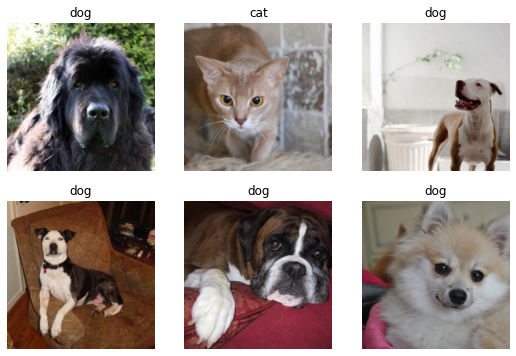

In [11]:
dls.show_batch(max_n=6)

**Creating the dataloader using Datablock api**




In [12]:
pets = DataBlock(blocks=(ImageBlock,CategoryBlock),
                 get_items= get_image_files,
                 splitter= RandomSplitter(),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms =Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [13]:
dls= pets.dataloaders(path/'images')

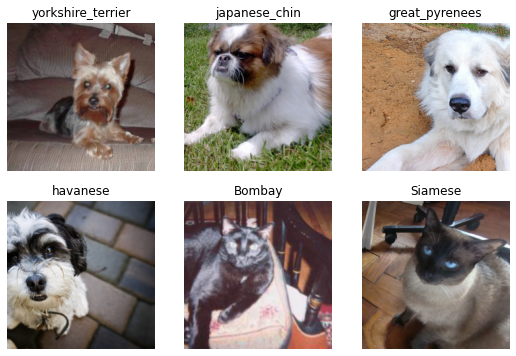

In [14]:
dls.show_batch(max_n=6)

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.499116,0.345162,0.108931,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.459600,0.264327,0.079161,01:06


In [16]:
learn.predict(files[1])


('Maine_Coon',
 tensor(6),
 tensor([5.7006e-05, 8.2909e-05, 2.2681e-05, 9.1371e-05, 9.5993e-04, 3.0771e-04,
         9.6558e-01, 3.0757e-02, 1.4060e-03, 3.1841e-05, 2.8040e-07, 2.3957e-06,
         1.0343e-06, 1.1983e-06, 1.7792e-06, 2.0975e-06, 5.3121e-06, 3.1146e-07,
         4.3127e-06, 8.3674e-06, 3.2055e-06, 4.8748e-06, 2.9409e-05, 3.4622e-05,
         6.9889e-05, 1.2871e-05, 2.1888e-06, 9.7269e-06, 4.7762e-04, 4.8562e-06,
         4.9944e-06, 6.7174e-06, 4.7875e-06, 3.2507e-06, 3.0335e-06, 7.5766e-06,
         1.6139e-06]))

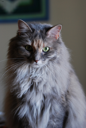

In [17]:
#the original image of files[0]

Image.open(files[1]).to_thumb(128,128)

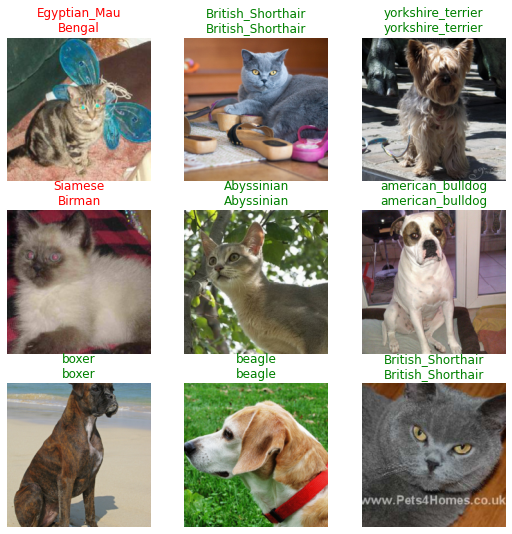

In [18]:
#checking the predictions
learn.show_results()

It's done a good job while predicting the images 

Now in this notebook we will go one step advanced by trying to predict the breed of the cat/dog

The breed of the cat/dog can be identfy from the file name of the image
eg :** /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_54.jpg'** the breed nam is Maine_Coon 
With the help of regualr expression and from_name_re function we can create dataloaders 

The breed classification is harder as compared with cat/dog classification we need to produce more data for learning the algorithm

With the help of the Augmentation we can produce more images 

SuggestedLRs(valley=tensor(4.3652e-05))

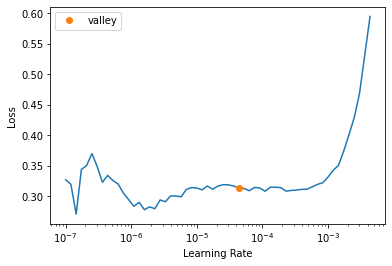

In [19]:
learn.lr_find()

Fine tuning the model with the learning rate

In [25]:
learn.fine_tune(2,4.3e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.255954,0.236285,0.071719,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.255331,0.234399,0.067659,01:09
1,0.255045,0.230790,0.066982,01:09


error rate got improved from 0.079 to 0.066 which is good thing now will check the results

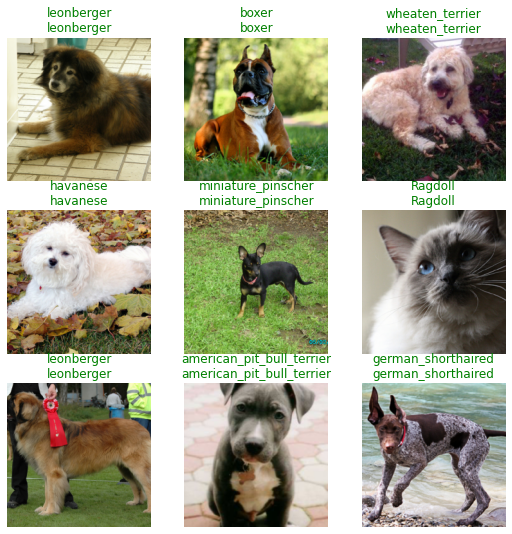

In [26]:
learn.show_results()

In [ ]:
#checking the worst predictions of the model with confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
#checking the top_losses

interp.plot_top_losses(5,figsize=(15,10))

**Manual trial**



We will try to use the finetune for the earlier layers with unfreeze method and we pass discriminate learinig rates to the layers to get better results

it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). 

fastai lets you pass a Python slice object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the lowest layer of our net to a learning rate of 1e-6; the other layers will scale up to 5e-5. Let's train for a while and see what happens:

In [31]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(2,4.3e-5)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,4.814275,3.118859,0.828146,01:03
1,3.988971,2.656599,0.707713,01:03


epoch,train_loss,valid_loss,error_rate,time
0,3.510349,2.140618,0.562923,01:07
1,2.524794,1.004056,0.242896,01:07
2,1.536283,0.586329,0.157645,01:06
3,1.074145,0.453496,0.135318,01:06
4,0.837244,0.394179,0.122463,01:07
5,0.737557,0.366011,0.118403,01:07
6,0.678829,0.358611,0.112991,01:06
7,0.664212,0.356935,0.113667,01:07


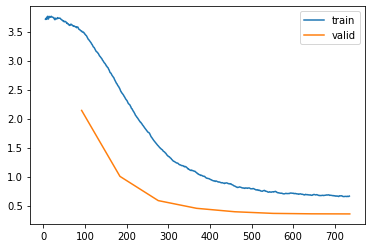

In [32]:
learn.recorder.plot_loss()

Can get better results if we go for further epochs


One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training

Using half precision floating point function in fastai to train faster with deep architecture



In [34]:
#using resnet50
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.226170,0.304871,0.100812,01:06
1,0.589059,0.307305,0.094046,01:04
2,0.399452,0.297582,0.091340,01:05


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.240299,0.275118,0.083897,01:06
1,0.323647,0.348354,0.102165,01:06
2,0.244045,0.313925,0.085927,01:06
3,0.149125,0.271147,0.066982,01:07
4,0.081161,0.229040,0.067659,01:07
5,0.049334,0.217992,0.062923,01:07


Slightly got improved by using large network with mixed precision training

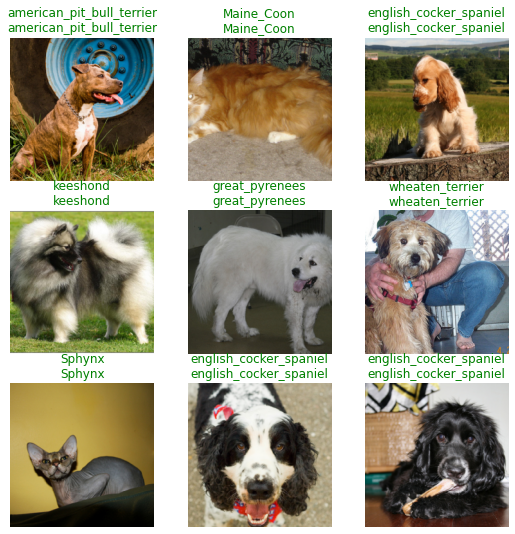

In [35]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


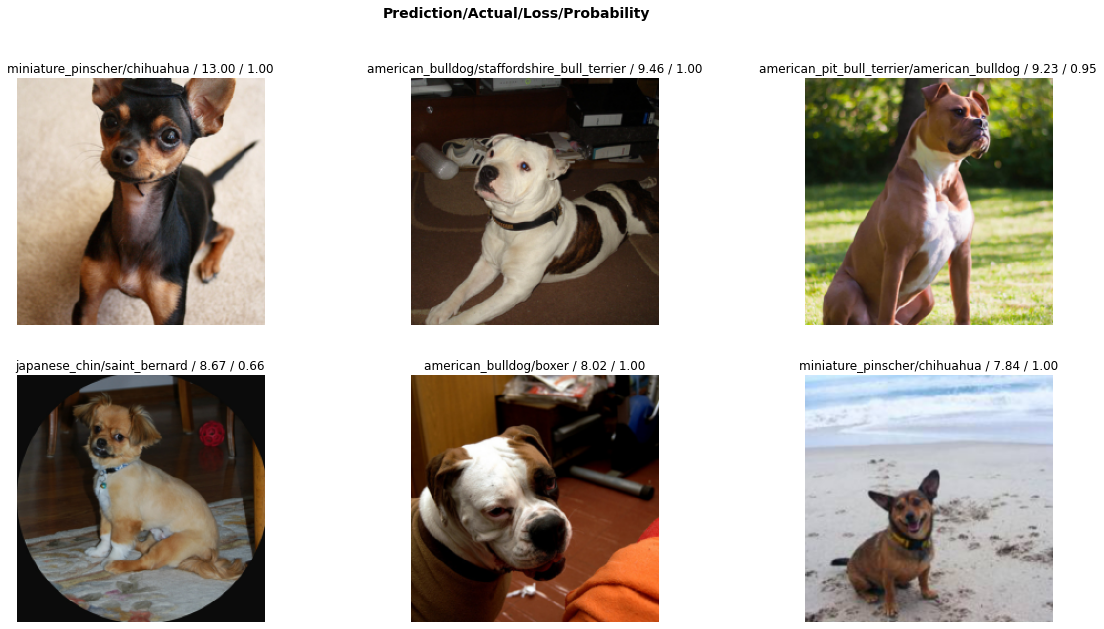

In [39]:
interp.plot_top_losses(6,figsize=(20,10))